<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">

# Project 3: Linear Regression and KNN - Train/Test Split

---

# Introduction

We've discussed overfitting in the context of bias and variance, and we've touched on some techniques, such as regularization, that are used to avoid overfitting (but haven't practiced them yet). In this lesson we'll discuss a fundamental method for avoiding overfitting that is commonly referred to as _train/test split_ validation. 

The idea is similar to something called "cross-validation" — in fact, it is a type of cross-validation — in that we split the data set into two subsets:
* A subset on which to train our model.
* A subset on which to test our model's predictions.

This serves two useful purposes:
* We prevent overfitting by not using all of the data.
* We have some remaining data we can use to evaluate our model.

While this may seem like a relatively simple idea, **there are some caveats** to putting it into practice. For example, if you are not careful, it is easy to take a non-random split. Suppose we have salary data on technical professionals that is composed of 80 percent data from California and 20 percent data from elsewhere and is sorted by state. If we split our data into 80 percent training data and 20 percent testing data, we might inadvertantly select all the California data to train and all the non-California data to test. In this case we've still overfit on our data set because we did not sufficiently randomize the data.

In a situation like this we can use _k-fold cross-validation_, which is the same idea applied to more than two subsets. In particular, we partition our data into $k$ subsets and train on $k-1$ one of them, holding the last slice for testing. We can do this for each of the possible $k-1$ subsets.

# Independent Practice

Ultimately we use a test-training split to compare multiple models on the same data set. This could be comparisons of two linear models or of completely different models on the same data.

For your independent practice, fit three different models on the Boston housing data. For example, you could pick three different subsets of variables, one or more polynomial models, or any other model you'd like. 

### Here's What We Will Be Doing:

* Working with Boston housing data to predict the value of a home
* Create a test-train split of the data.
* Train each of your models on the training data.
* Evaluate each of the models on the test data.
* Rank the models by how well they score on the testing data set.

**Then, try k-folds.**

* Try a few different splits of data for the same models.
* Perform a k-fold cross-validation and use the cross-validation scores to compare your models. Did this change your rankings?

**Be sure to provide interpretation for your results.**

Recall that k-fold cross-validation creates a hold portion of your data set for each iteration of training and validating:

![](http://i.imgur.com/0PFrPXJ.png)

## Linear Regression Use Case

In this given task, you will be asked to model the median home price of various houses across U.S. Census tracts in the city of Boston. This is a probable use case: We are predicting a continuous, numeric output (price) based on a combination of discrete features.

In [65]:
import matplotlib.pyplot as plt

%matplotlib inline

In [44]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_boston

boston = load_boston()

X = pd.DataFrame(boston.data,
                 columns=boston.feature_names)
y = pd.DataFrame(boston.target,
                 columns=['MEDV'])

print(boston['DESCR'])

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [45]:
boston.feature_names

array(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'TAX', 'PTRATIO', 'B', 'LSTAT'], dtype='<U7')

### 1. Clean Up Data and Perform Exporatory Data Analysis

Boston data is from scikit-learn, so it ought to be pretty clean, but we should always perform exploratory data analysis.

In [46]:
# Exploratory data analysis.

# Include: total nulls, index, data types, shape, summary statistics, and the number of unique values for each column
X.isnull().sum() #no null value in X

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
dtype: int64

In [47]:
X.info() #Index of the Boston dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
CRIM       506 non-null float64
ZN         506 non-null float64
INDUS      506 non-null float64
CHAS       506 non-null float64
NOX        506 non-null float64
RM         506 non-null float64
AGE        506 non-null float64
DIS        506 non-null float64
RAD        506 non-null float64
TAX        506 non-null float64
PTRATIO    506 non-null float64
B          506 non-null float64
LSTAT      506 non-null float64
dtypes: float64(13)
memory usage: 51.5 KB


In [48]:
X.shape

(506, 13)

In [49]:
X.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [50]:
X.apply(lambda x: x.nunique()) #number of unique values for each column

CRIM       504
ZN          26
INDUS       76
CHAS         2
NOX         81
RM         446
AGE        356
DIS        412
RAD          9
TAX         66
PTRATIO     46
B          357
LSTAT      455
dtype: int64

In [51]:
y.isnull().sum()

MEDV    0
dtype: int64

## Using `scikit-learn` Linear Regression

### 2. Pick 3-4 predictors (i.e. CRIM, ZN, etc...) that you will use to predict our target variable, MEDV.
Score and plot your predictions. What do these results tell us?

In [52]:
import seaborn as sns
from sklearn.linear_model import LinearRegression


# Create X and y.
feature_cols = ['CRIM','ZN','DIS'] 

#using per capita crime rate by town
#proportion of residential land zoned for lots over 25,000 sq.ft.
#weighted distances to five Boston employment centres as target variables
X = X[feature_cols]
y = boston.target

# Instantiate and fit.
linreg = LinearRegression()
linreg.fit(X, y)

# Print the coefficients.
print(linreg.intercept_)
print(linreg.coef_)

24.60177659493837
[-0.39128219  0.1506196  -0.62361596]


In [53]:
list(zip(feature_cols, linreg.coef_)) #list all the coef

[('CRIM', -0.3912821882070882),
 ('ZN', 0.1506195956539365),
 ('DIS', -0.623615957753287)]

### 3. Try 70/30 and 90/10 train/test splits (70% of the data for training - 30% for testing, then 90% for training - 10% for testing)
Score and plot. How do your metrics change? What does this tell us about the size of training/testing splits?

In [54]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 2)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(354, 3) (152, 3) (354,) (152,)


In [55]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 3)
print( X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(455, 3) (51, 3) (455,) (51,)


### 4. Use k-fold cross validation varying the number of folds from 5 to 10
What seems optimal? How do your scores change? What is the variance like? Try different folds to get a sense of how this impacts your score. What are the tradeoffs associated with choosing the number of folds?

In [56]:
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5, shuffle=True) #when k=5

print(np.mean(-cross_val_score(linreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(linreg, X, y, cv=kf)))

64.38729072230205
0.2229395296851701


In [57]:
kf = KFold(n_splits=6, shuffle=True) #when k=6

print(np.mean(-cross_val_score(linreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(linreg, X, y, cv=kf)))

66.37485087794495
0.21397619741413107


In [58]:
   kf = KFold(n_splits=7, shuffle=True) #when k=7

print(np.mean(-cross_val_score(linreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(linreg, X, y, cv=kf))) 

65.4834705782147
0.2170574816687998


In [59]:
kf = KFold(n_splits=8, shuffle=True) #when k=8

print(np.mean(-cross_val_score(linreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(linreg, X, y, cv=kf)))

65.67096319449419
0.21525160249613928


In [60]:
kf = KFold(n_splits=9, shuffle=True) #when k=9

print(np.mean(-cross_val_score(linreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(linreg, X, y, cv=kf)))

66.08247195945751
0.22491615678416682


In [61]:
kf = KFold(n_splits=10, shuffle=True) #when k=10

print(np.mean(-cross_val_score(linreg, X, y, cv=kf, scoring='neg_mean_squared_error')))
print(np.mean(cross_val_score(linreg, X, y, cv=kf)))

65.20992939723462
0.23491989343598968


# KNN Practice

In [77]:
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
# Read the iris data into a DataFrame
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'

col_names = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width', 'species']
iris = pd.read_csv(url, header=None, names=col_names)

In [78]:
# Create a custom colormap
from matplotlib.colors import ListedColormap

cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

In [81]:
iris.head()

# Increase the default figure and font sizes for easier viewing
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['font.size'] = 15

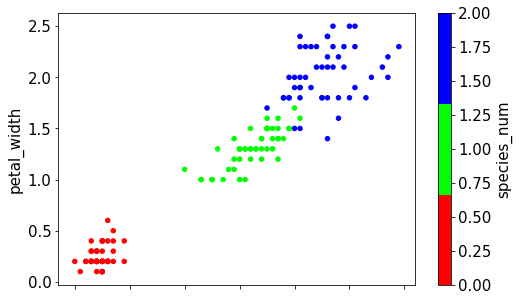

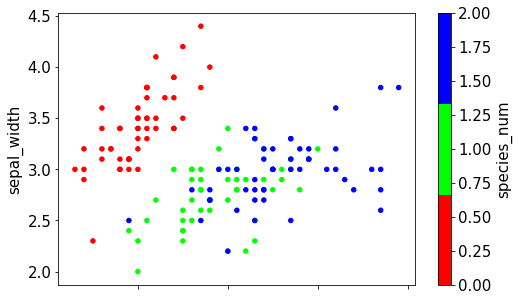

In [82]:
# Map each iris species to a number
# Let's use Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2 and create a column called 'species_num'
iris['species_num'] = iris.species.map({'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2})
# Create a scatterplot of PETAL LENGTH versus PETAL WIDTH and color by SPECIES
iris.plot(x='petal_length', y='petal_width', c='species_num', kind='scatter', colormap=cmap_bold); 
# Create a scatterplot of SEPAL LENGTH versus SEPAL WIDTH and color by SPECIES
iris.plot(kind='scatter', x='sepal_length', y='sepal_width', c='species_num', colormap=cmap_bold);

##### Another Method, just factorize the species

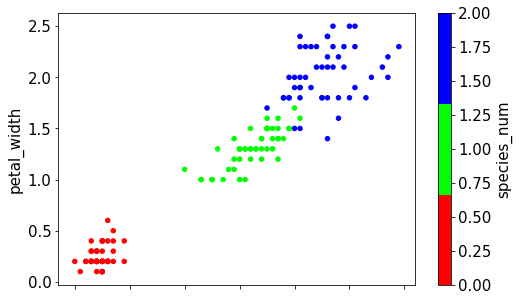

In [83]:
# Map each iris species to a number
iris['species_num'] = iris.species.factorize()[0]
iris.plot(kind='scatter', x='petal_length', y='petal_width', c='species_num', colormap= cmap_bold);

## KNN Classification of the Iris Dataset

### Create your feature matrix "X"
This will be all species measurements (sepal length, petal width, etc...)

In [84]:
feature_cols = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
X = iris[feature_cols]

### Create your target vector "y"
This will be the species type.

In [85]:
y = iris.species_num

### Make Use of Train-Test-Split
Split your data in to train and test sets.

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 3)
print( X_train.shape, X_test.shape, y_train.shape, y_test.shape )

(135, 4) (15, 4) (135,) (15,)


### Import KNN From `scikit-learn` and Instatiate a Model With One Neighbor

In [87]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
print(knn)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')


### Check the Accuracy
Train your model using the training set then use the test set to determine the accuracy

In [88]:
from sklearn import metrics
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

1.0


### Create a Model With Five Neighbors. Did it Improve?

In [89]:
knn = KNeighborsClassifier(n_neighbors=5)
print((metrics.accuracy_score(y_test, y_pred_class)))

1.0


### Create a Looped Function That Will Check All Levels of Various Neighbors and Calculate the Accuracy

In [91]:
# creating list of K for KNN
k_list = list(range(1,50,2))
# creating list of cv scores
cv_scores = []

# perform 10-fold cross validation
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
    cv_scores.append(scores.mean())

<Figure size 576x360 with 0 Axes>

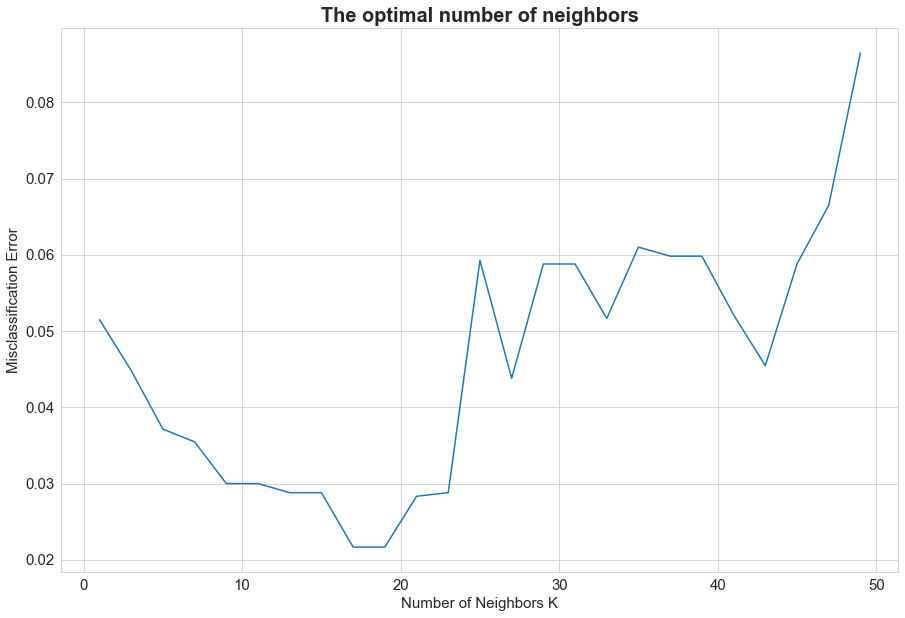

In [98]:
# changing to misclassification error
MSE = [1 - x for x in cv_scores];

plt.figure();
plt.figure(figsize=(15,10));
plt.title('The optimal number of neighbors', fontsize=20, fontweight='bold');
plt.xlabel('Number of Neighbors K', fontsize=15);
plt.ylabel('Misclassification Error', fontsize=15);
sns.set_style("whitegrid");
plt.plot(k_list, MSE);

plt.show();

In [99]:
# finding best k
best_k = k_list[MSE.index(min(MSE))]
print("The optimal number of neighbors is %d." % best_k)

The optimal number of neighbors is 17.


### Bonus: According to `scikit-learn` Documentation, What is `knn.predict_proba(X_new)` Going to Do?

## Enrichment
_Everything beyond this point is enrichment and examples using Statsmodels for linear regression._

### Example: Using the Statsmodels Formula

Adapt the formula example using your metrics. We will review this implementation in class. Here is a reference to consider. The workflow is the same, but the syntax is a little different. We want to get accustomed to the formula syntax because we will be using them a lot more with regressions. The results should be comparable to scikit-learn's regression models.

In [100]:
# First, format our data in a DataFrame

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['MEDV'] = boston.target
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


In [101]:
# Set up our new statsmodel.formula handling model
import statsmodels.formula.api as smf

# You can easily swap these out to test multiple versions/different formulas
formulas = {
    "case1": "MEDV ~ RM + LSTAT + RAD + TAX + NOX + INDUS + CRIM + ZN - 1", # - 1 = remove intercept
    "case2": "MEDV ~ NOX + RM",
    "case3": "MEDV ~ RAD + TAX"
}

model = smf.ols(formula=formulas['case1'], data=df)
result = model.fit()

result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   MEDV   R-squared (uncentered):                   0.951
Model:                            OLS   Adj. R-squared (uncentered):              0.951
Method:                 Least Squares   F-statistic:                              1221.
Date:                Wed, 20 Nov 2019   Prob (F-statistic):                   1.38e-321
Time:                        23:04:52   Log-Likelihood:                         -1567.5
No. Observations:                 506   AIC:                                      3151.
Df Residuals:                     498   BIC:                                      3185.
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
RM             4.9729      0.224     22.195      0.000       4.533       5.413
LSTAT         -0.5606      0.048    -11.795      0.000      -0.654      -0.467
RAD            0.2128      0.070      3.050      0.002       0.076       0.350
TAX           -0.0174      0.004     -4.272      0.000      -0.025      -0.009
NOX            4.3448      3.384      1.284      0.200      -2.304      10.994
INDUS          0.0924      0.067      1.383      0.167      -0.039       0.224
CRIM          -0.0891      0.037     -2.423      0.016      -0.161      -0.017
ZN             0.0288      0.013      2.220      0.027       0.003       0.054
==============================================================================
Omnibus:                      192.139   Durbin-Watson:                   0.812
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              832.155
Skew:                           1.666   Prob(JB):                    1.99e-181
Kurtosis:                       8.326   Cond. No.                     6.24e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.24e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Bonus Challenge #1:

Can you optimize your R2, selecting the best features and using either test-train split or k-folds?

### Bonus Challenge #2:

Given a combination of predictors, can you find another response variable that can be accurately predicted through the exploration of different predictors in this data set?

_Tip: Check out pairplots, coefficients, and Pearson scores._

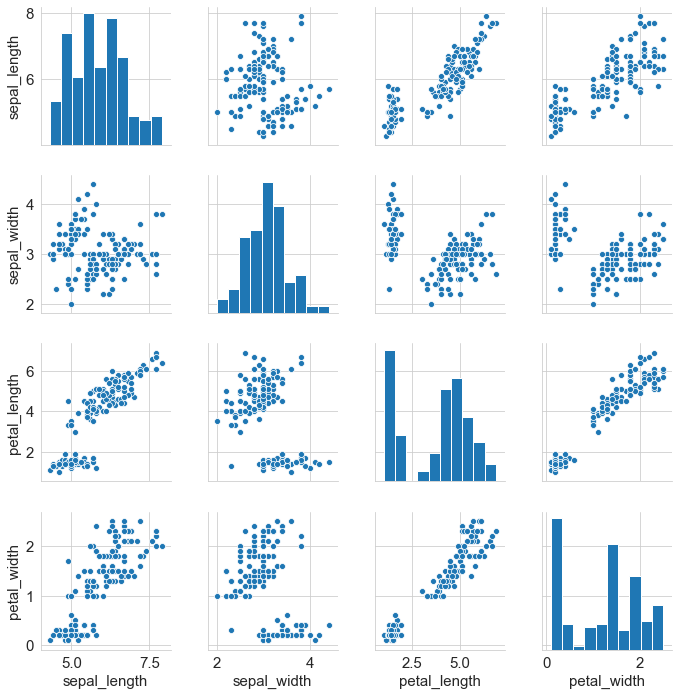

In [102]:
# Check out variable relations
import seaborn as sns

sns.pairplot(X);

In [ ]:
# Check out Pearson scores


## Demo: Patsy

In [103]:
import patsy

# Add response to the core DataFrame
df['MEDV'] = y

In [104]:
from sklearn.model_selection import train_test_split #If you didn't import it earlier, do so now

# Easily change your variable predictors without reslicing your DataFrame
y, X = patsy.dmatrices("MEDV ~ AGE + RM", data=df, return_type="dataframe")

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7)


In [105]:
from sklearn import metrics
from sklearn.linear_model import LinearRegression

# Rerun your model, iteratively changing your variables and train_size from the previous cell

lm = LinearRegression()
model = lm.fit(X_train, y_train)

predictions = model.predict(X_test)
print("R^2 Score: {}".format(metrics.r2_score(y_test, predictions)))

R^2 Score: -0.025262310320556258
